In [2]:
# Imports
from os.path import exists
from pathlib import Path

import math

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn # Includes all modules, nn.Linear, nn.Conv2d, BatchNorm etc
import torch.optim as optim # Is used for otimization algorithms such as Adam, SGD ...
from torch.utils.data import DataLoader # Helps with managing datasets in mini batches
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as datasets # Has standard datasets
import torchvision.transforms as transforms # Transformations to be used on images
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.models import vgg19

from itertools import chain
from PIL import Image

# from model import Generator, Discriminator # Models inspired from SRGAN

In [3]:
print("cuda is available: " + str(torch.cuda.is_available()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is set to: " + str(device))

cuda is available: True
Device is set to: cuda


In [4]:
class Generator(nn.Module):
    def __init__(self, num_channels=64, scale_factor=2):
        super(Generator, self).__init__()
        self.init_layers = nn.Sequential(
            nn.Conv2d(3, num_channels, 9, padding=4),
            nn.PReLU(num_parameters = num_channels),
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_channels,num_channels) for _ in range(16)]
        )
        
        #self.inception_blocks = nn.Sequential(
        #    InceptionBlock(num_channels, red_3x3=32, red_5x5=16, out_1x1 = 64, out_3x3 = 64, out_5x5 = 32, out_1x1pool = 32),
        #    InceptionBlock(192, red_3x3=96, red_5x5=16, out_1x1 = 64, out_3x3 = 128, out_5x5 = 32, out_1x1pool = 32),
        #    InceptionBlock(256, red_3x3=128, red_5x5=32, out_1x1 = 128, out_3x3 = 192, out_5x5 = 96, out_1x1pool = 64),
        #    
        #    InceptionBlock(480, red_3x3 = 96, red_5x5 = 16, out_1x1 = 192, out_3x3 = 208, out_5x5 = 48, out_1x1pool = 64),
        #    InceptionBlock(512, red_3x3 = 112, red_5x5 = 24, out_1x1 = 160, out_3x3 =224, out_5x5 = 64, out_1x1pool = 64),
        #    InceptionBlock(512, red_3x3 = 128, red_5x5 = 24, out_1x1 = 128, out_3x3 =256, out_5x5 = 64, out_1x1pool = 64),
        #    InceptionBlock(512, red_3x3 = 112, red_5x5 = 24, out_1x1 = 160, out_3x3 =224, out_5x5 = 64, out_1x1pool = 64),
        #    InceptionBlock(512, red_3x3 = 128, red_5x5 = 24, out_1x1 = 128, out_3x3 =256, out_5x5 = 64, out_1x1pool = 64),
        #    InceptionBlock(512, red_3x3 = 144, red_5x5 = 32, out_1x1 = 112, out_3x3 =288, out_5x5 = 64, out_1x1pool = 64),
        #    InceptionBlock(528, red_3x3 = 128, red_5x5 = 24, out_1x1 = 128, out_3x3 =256, out_5x5 = 64, out_1x1pool = 64),
        #    
        #    InceptionBlock(512, red_3x3=96, red_5x5=16, out_1x1 = 64, out_3x3 = 128, out_5x5 = 32, out_1x1pool = 32),
        #    InceptionBlock(256, red_3x3=32, red_5x5=16, out_1x1 = 64, out_3x3 = 64, out_5x5 = 32, out_1x1pool = 32),
        #    InceptionBlock(192, red_3x3 = 32, red_5x5 = 16, out_1x1 = 16, out_3x3 =32, out_5x5 = 8, out_1x1pool = 8),
        #)
        
        self.final_residual_block = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
        )
        self.upsample_blocks = nn.Sequential(
            UpsampleBlock(num_channels,scale_factor),
            UpsampleBlock(num_channels,scale_factor),
        )
        self.output_layer = nn.Conv2d(num_channels, 3, 9, padding=4);
    
    def forward(self, x):
        # Save the output from initial conv layers so that we can add it to our skip connection before upsampling
        out_init_layers = self.init_layers(x)
        out_residual_blocks = self.residual_blocks(out_init_layers)
        out_final_residual_block = self.final_residual_block(out_residual_blocks) + out_init_layers
        out_upsample_blocks = self.upsample_blocks(out_final_residual_block)
        return self.output_layer(out_upsample_blocks);


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, red_3x3, red_5x5, out_1x1, out_3x3, out_5x5, out_1x1pool):
        super(InceptionBlock, self).__init__()
        
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_1x1),
            nn.PReLU(num_parameters=out_1x1)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1, bias=False),
            nn.BatchNorm2d(red_3x3),
            nn.PReLU(num_parameters=red_3x3),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_3x3),
            nn.PReLU(num_parameters=out_3x3)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1, bias=False),
            nn.BatchNorm2d(red_5x5),
            nn.PReLU(num_parameters=red_5x5),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(out_5x5),
            nn.PReLU(num_parameters=out_5x5)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_1x1pool, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_1x1pool),
            nn.PReLU(num_parameters=out_1x1pool),
        )
    
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)        
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels=64, num_channels=64):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.PReLU(num_parameters = num_channels),
            nn.Conv2d(num_channels, num_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_channels)
        )
        
    def forward(self, x):
        return self.block(x) + x
        
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.block = nn.Sequential(
            # The number of output filters is altered to be in_channels * sf^2 so that pixel shuffle (next layer) can upscale image
            nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 3, padding=1, bias=False),
            nn.PixelShuffle(scale_factor), #  in_channels * scale_factor^2, height, width -> in_channels, height*2, width*2
            nn.PReLU(num_parameters=in_channels),
        )
    def forward(self, x):
        return self.block(x)


In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, img_size, in_channels=3):
        super(Discriminator, self).__init__()
        
        self.feature_layers = nn.Sequential(
            *[
            nn.Conv2d(in_channels, 64, 3, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 64, 3, 2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 3, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 128, 3, 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 3, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 256, 3, 2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 3, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 512, 3, 2, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True) 
        ]
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.classifier(self.feature_layers(x))

In [6]:
class Data(Dataset):
    
    def __init__(self, datapath, high_res_size, low_res_size):
        datapath = Path(datapath)
        if not (datapath.exists() and datapath.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.datapath = datapath
        
        # Set transforms
        self.transform_both = T.Compose([T.RandomHorizontalFlip(p=0.5), T.RandomRotation((-180, 180)), T.RandomCrop((high_res_size, high_res_size), pad_if_needed=True)])
        self.transform_low = T.Compose([T.Resize((low_res_size, low_res_size), Image.BICUBIC), T.ToTensor(), T.Normalize([0,0,0] ,[1,1,1])])
        self.transform_high = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) # NOTE: Normalization to range [-1,1] is only done for hr images according to paper
        
        # Collect samples
        self.samples = self.collect_samples()
            
    def __getitem__(self, index):
        # Access the stored path and label for the correct index
        img_path = self.samples[index]
        # Load the image into memory
        
        # Convert to image data with RGB (3 channels)
        high_res_img = Image.open(img_path).convert('RGB')
        high_res_img = self.transform_both(high_res_img)
        low_res_img = high_res_img.copy()
          
        # Perform transforms, if any.
        high_res_img = self.transform_high(high_res_img)
        low_res_img = self.transform_low(low_res_img)
        return high_res_img, low_res_img
    
    def __len__(self):
        return len(self.samples)
        
    
    def collect_samples(self):
        if not self.datapath.exists():
            raise ValueError(f"Data root '{self.datapath}' must contain sub dir '{self.datapath.name}'")
        
        # Finds all pathnames matching a specified pattern
        file_extensions = ['jpg', 'jpeg', 'png']
        img_paths = []
        for file_extension in file_extensions:
            img_paths += list(self.datapath.rglob("*." + file_extension))
            
        return img_paths
     
    
    def get_sample_by_name(self, name, img_size=24):
        try:
            img_path = next(path for path in self.samples if path.stem == name)
        except StopIteration:
            print("No image with specified name found. Returning a random image")
            img_path = self.samples[1]
        img = Image.open(img_path).convert('RGB')
        
        return F.to_tensor(F.resize(img ,size = [img_size, img_size], interpolation = Image.BICUBIC))
       


In [7]:
def display_image(axis, image_tensor, reverse_normalization = False):
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    
    # Assuming our normalization on the image is mean=0.5 and std=0.5 for all channels we can do this to more accurately display the image
    if reverse_normalization:
        image_data = 0.5 * image_data + 0.5
    
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)


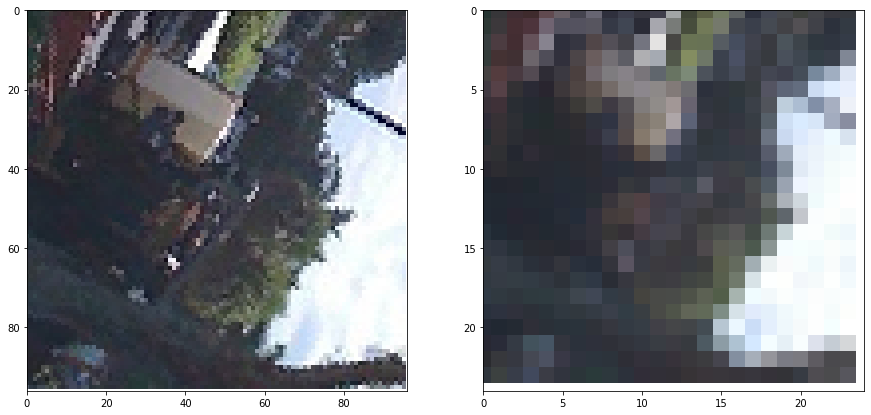

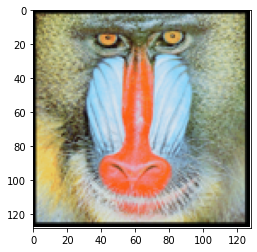

In [8]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
high_res_size = 96
low_res_size = 24

example_dataset = Data("./dataset/", high_res_size ,low_res_size);
fig, axis = plt.subplots(1,2, figsize=(15,15))
some_random_index = 4
high_res_image_tensor, low_res_image_tensor = example_dataset[some_random_index]
display_image(axis[0], high_res_image_tensor, True)
display_image(axis[1], low_res_image_tensor)

fig, axis = plt.subplots()
display_image(axis, example_dataset.get_sample_by_name('baboon', 128))


In [9]:
# class for content loss function to penalize if features don't match between generated and target image
class VGGContentLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Extract the features of vgg19 network
        self.low_level_feature_layers = vgg19(pretrained=True).features[:8].eval().to(device)
        self.high_level_feature_layers = vgg19(pretrained=True).features[8:18].eval().to(device)
        # Use mean squared error loss for feature diffs
        self.mse = nn.MSELoss().to(device)
        
        for param in self.low_level_feature_layers.parameters():
            param.requires_grad = False
            
        for param in self.high_level_feature_layers.parameters():
            param.requires_grad = False
            
        # The preprocessing method of the input data. This is the VGG model preprocessing method of the ImageNet dataset.
        self.register_buffer("mean", torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, gen_img, target_img):
        gen_low_level_features = self.low_level_feature_layers(gen_img)
        target_low_level_features = self.low_level_feature_layers(target_img)
        
        gen_high_level_features = self.high_level_feature_layers(gen_low_level_features)
        target_high_level_features = self.high_level_feature_layers(target_low_level_features)
        
        return self.mse(gen_low_level_features, target_low_level_features) + self.mse(gen_high_level_features, target_high_level_features)

In [10]:
def train(dataloader,  generator,discriminator, disc_opti, gen_opti, gen_opti_pretrain, adversarial_criterion, content_criterion, pixel_criterion, num_epochs, adversarial=True):
    print('##################\n%s\n##################' % ('Starting ADVERSARIAL training' if adversarial else 'Starting GENERATOR training'))
    
    # Set training mode
    discriminator.train()
    generator.train()
    
    # Initialize loss-lists
    disc_losses = []
    gen_losses = []
    
    # Matplotlib to visualize training progression
    %matplotlib qt
    fig = plt.figure(figsize=(15, 12))
    ax_lr_dynamic = plt.subplot2grid((3, 6), (0, 0), colspan=2)
    ax_sr_dynamic = plt.subplot2grid((3, 6), (0, 2), colspan=2)
    ax_hr_dynamic = plt.subplot2grid((3, 6), (0, 4), colspan=2)
    
    ax_lr_fixed = plt.subplot2grid((3, 6), (1, 0), colspan=2)
    ax_sr_fixed = plt.subplot2grid((3, 6), (1, 2), colspan=2)
    ax_hr_fixed = plt.subplot2grid((3, 6), (1, 4), colspan=2)

    ax_disc_loss = plt.subplot2grid((3, 6), (2, 0), colspan=3)
    ax_gen_loss = plt.subplot2grid((3, 6), (2, 3), colspan=3)
    
    memory_allocated_for_tensors = 0
    
    for epoch in range(1, num_epochs + 1):
        for batch_index, (high_res_batch, low_res_batch) in enumerate(dataloader, 1):
            
            # Transfer high res and low res image tensors to device
            high_res_batch = high_res_batch.to(device)
            low_res_batch = low_res_batch.to(device)
            
            # Generate fake images with the generator
            fake_batch = generator(low_res_batch)
            
            # If training with adversarial include discriminator and update it
            if adversarial:
                # [1] Update Discriminator network: maximize log(D(x)) + log(1-D(G(Z)))

                # Initialize the gradient of the discriminator model.
                discriminator.zero_grad()

                # [1.1] Train discriminator with real images
                real_preds = discriminator(high_res_batch)
                real_labels = torch.ones_like(real_preds, device=device)
                disc_real_loss = adversarial_criterion(real_preds, real_labels)

                # [1.2] Train discriminator with fake generated images
                fake_preds = discriminator(fake_batch.detach())
                fake_labels = torch.zeros_like(fake_preds, device=device)
                disc_fake_loss = adversarial_criterion(fake_preds, fake_labels)

                # Discriminator loss
                disc_loss = disc_real_loss + disc_fake_loss
                # Calculate discriminator gradient
                disc_loss.backward()
                # Update discriminator parameters
                disc_opti.step()
                # Append loss
                #disc_losses.append(disc_loss.detach().item())
                
                D_x = real_preds.mean().detach().item()
                D_G_z1 = fake_preds.mean().detach().item()


            # [2] Update Genertaor network: maximize log(D(G(z)))
            
            # Initialize the gradient of the generator model.
            generator.zero_grad()
            
            gen_loss = None #Initialize gen loss for batch
            
            if adversarial:
                # Generator wants the discriminator to output 1 on its generated images
                new_fake_preds = discriminator(fake_batch)
                gen_desirable_labels = torch.ones_like(new_fake_preds, device=device)

                # Generator loss is based on a weighted sum of adversarial loss and content loss
                adversarial_loss = adversarial_criterion(new_fake_preds, gen_desirable_labels)
                content_loss = content_criterion(fake_batch, high_res_batch.detach())
                pixel_loss = pixel_criterion(fake_batch, high_res_batch.detach())

                # Adversarial training
                gen_loss = 1e-3 * pixel_loss + 0.006 * content_loss + 5 * 1e-3 * adversarial_loss
                
                # Calculate gradients for Generator
                gen_loss.backward()

                # Update Generator
                gen_opti.step()
                
                 # Save mean of new fake preds
                D_G_z2 = new_fake_preds.mean().detach().item()
            else:
                # Exclusive generator training
                gen_loss = pixel_criterion(fake_batch, high_res_batch.detach())
                
                # Calculate gradients for Generator
                gen_loss.backward()
                
                # Update Generator
                gen_opti_pretrain.step()
                
            #gen_losses.append(gen_loss.detach().item())
                
            # plot and print progression every x:th batch
            if batch_index % 50 == 0:
                if adversarial:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, batch_index, len(dataloader),
                             disc_loss.item(), gen_loss.item(), D_x, D_G_z1, D_G_z2))
                else:
                    print('[%d/%d][%d/%d]\tLoss_G: %.4f'
                          % (epoch, num_epochs, batch_index, len(dataloader), gen_loss.item()))
                    
                # plot images
                with torch.no_grad():
                     # Display images to visualize current state in training
                    display_image(ax_lr_dynamic, low_res_batch[-1].cpu().detach())
                    display_image(ax_sr_dynamic, fake_batch[-1].cpu().detach(), reverse_normalization = True)
                    display_image(ax_hr_dynamic, high_res_batch[-1].cpu().detach(), reverse_normalization = True)
                    display_image(ax_lr_fixed, dataloader.dataset.get_sample_by_name('baboon', 128))
                    display_image(ax_sr_fixed, generator.forward(torch.unsqueeze(dataloader.dataset.get_sample_by_name('baboon', 128).cuda().detach(), 0))[-1].cpu(), reverse_normalization = True)
                    display_image(ax_hr_fixed, dataloader.dataset.get_sample_by_name('baboon', 512))
                    ax_disc_loss.plot(disc_losses)
                    ax_disc_loss.set_title('Discriminator loss')
                    ax_gen_loss.plot(gen_losses)
                    ax_gen_loss.set_title('Generator loss')
                    plt.pause(0.5)
                    fig.show()
                
                # Detect memory increases for potential memory leaks
                if memory_allocated_for_tensors == 0:
                    memory_allocated_for_tensors = torch.cuda.memory_allocated()
                elif memory_allocated_for_tensors != torch.cuda.memory_allocated():
                    print('[Memory increase alert] If this is a reoccuring print statement. Program might be subject to memory leak!')
                    print('Current memory is: ' + str(torch.cuda.memory_allocated()))
                    memory_allocated_for_tensors = torch.cuda.memory_allocated()            

    %matplotlib inline
    
    return generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain
    


In [11]:
class ModelLoader:
    
    def __init__(self):
        self.saved_model_path = './saved-models'
    
    def save_models(self, generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr):
        print('Saving procedure initialized..')
        stem = input("Enter stem of path (leave empty if you don't want to save): ")
        
        if stem:
            PATH = self.saved_model_path + '/' + str(stem) + '.pt'
            
            if exists(PATH):
                overwrite = input('There already exist a checkpoint with this name. Do you want to overwrite? (Write YES)')
                if overwrite != 'YES':
                    print('Interrupting saving models (no overwrite)')
                    return
            
            torch.save({
                'generator_state_dict':generator.state_dict(),
                'discriminator_state_dict':discriminator.state_dict(),
                'gen_opti_state_dict': gen_opti.state_dict(),
                'disc_opti_state_dict': disc_opti.state_dict(),
                'gen_opti_pretrain_state_dict': gen_opti_pretrain.state_dict(),
                'high_res_size': high_res_size,
                'low_res_size':low_res_size,
                'scaling_factor':scaling_factor,
                'batch_size':batch_size,
                'num_epochs':num_epochs,
                'gen_lr: ':gen_lr,
                'disc_lr': disc_lr,
            }, PATH)
            if exists(PATH):
                print('Saved succesfully')
        else:
            print('Interrupting saving models (no path specified)')
            return
            
    def load_models(self):
        print('Load procedure initialized..')
        stem = input('Enter stem of path (leave empty for new models): ')
        if stem:
            PATH = self.saved_model_path + '/' + str(stem) + '.pt'
            
            if exists(PATH):
                print('Loading existing models')
                checkpoint = torch.load(PATH)
                # Load generator
                generator = Generator()
                generator.load_state_dict(checkpoint['generator_state_dict'])
                generator.to(device)

                # Load discriminator
                discriminator = Discriminator(checkpoint['high_res_size'])
                discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
                discriminator.to(device)

                # Load optimizers
                disc_opti = optim.Adam(discriminator.parameters(), lr=checkpoint['disc_lr'], betas=(0.9, 0.999))
                disc_opti.load_state_dict(checkpoint['disc_opti_state_dict']) 
                gen_opti = optim.Adam(generator.parameters(), lr=checkpoint['gen_lr'], betas=(0.9, 0.999))
                gen_opti.load_state_dict(checkpoint['gen_opti_state_dict'])
                gen_opti_pretrain = optim.Adam(generator.parameters(), lr=checkpoint['gen_lr'], betas=(0.9, 0.999))
                gen_opti_pretrain.load_state_dict(checkpoint['gen_opti_pretrain_state_dict'])     
                
                # Initialize loss functions that are used for perceptual and adversarial loss
                adversarial_criterion = nn.BCELoss().to(device)
                content_criterion = VGGContentLoss()
                pixel_criterion = nn.MSELoss().to(device)

                # Training parameters
                high_res_size = checkpoint['high_res_size']
                low_res_size = checkpoint['low_res_size']
                scaling_factor = checkpoint['scaling_factor']
                batch_size = checkpoint['batch_size']
                num_epochs = checkpoint['num_epochs']
                gen_lr = checkpoint['gen_lr']
                disc_lr = checkpoint['disc_lr']
                print('high_res_size: ' + str(high_res_size))
                print('low_res_size: ' + str(low_res_size))
                print('scaling_factor: ' + str(scaling_factor))
                print('batch_size: ' + str(batch_size))
                print('num_epochs: ' + str(num_epochs))
                print('gen_lr: ' + str(gen_lr))
                print('disc_lr: ' + str(disc_lr))
                return generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr, adversarial_criterion, content_criterion, pixel_criterion
            else:
                print('Path ' + PATH + '  does not exist')
        
        print('Loading models from scratch')
        batch_size = 16
        num_epochs = 125
        scaling_factor = 2
        high_res_size = 96
        low_res_size = high_res_size//(scaling_factor**2)
        gen_lr = 1e-4
        disc_lr = 1e-4

        generator = Generator().to(device)
        discriminator = Discriminator(high_res_size).to(device)

        disc_opti = optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.9, 0.999))
        gen_opti = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.9, 0.999))
        gen_opti_pretrain = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.9, 0.999))
        
        # Initialize loss functions that are used for perceptual and adversarial loss
        adversarial_criterion = nn.BCELoss().to(device)
        content_criterion = VGGContentLoss()
        pixel_criterion = nn.MSELoss().to(device)
        print('high_res_size: ' + str(high_res_size))
        print('low_res_size: ' + str(low_res_size))
        print('scaling_factor: ' + str(scaling_factor))
        print('batch_size: ' + str(batch_size))
        print('num_epochs: ' + str(num_epochs))
        print('gen_lr: ' + str(gen_lr))
        print('disc_lr: ' + str(disc_lr))
        return generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr, adversarial_criterion, content_criterion, pixel_criterion

In [12]:
# Initialize models (with ModelLoader)
model_loader = ModelLoader()

generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr, adversarial_criterion, content_criterion, pixel_criterion = model_loader.load_models()
dataset = Data("./dataset/", high_res_size ,low_res_size);
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Load procedure initialized..
Enter stem of path (leave empty for new models): 
Loading models from scratch
high_res_size: 96
low_res_size: 24
scaling_factor: 2
batch_size: 16
num_epochs: 125
gen_lr: 0.0001
disc_lr: 0.0001


In [12]:
# TRAINING TIME!

# Generator training (Pretraining)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain = train(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, adversarial_criterion, content_criterion, pixel_criterion, num_epochs = 25, adversarial=False)

# Adversarial training (Regular Training)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain = train(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, adversarial_criterion, content_criterion, pixel_criterion, num_epochs, adversarial=True)

##################
Starting GENERATOR training
##################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/25][50/157]	Loss_G: 0.0495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/25][100/157]	Loss_G: 0.0581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/25][150/157]	Loss_G: 0.0359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/25][50/157]	Loss_G: 0.0453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/25][100/157]	Loss_G: 0.0291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/25][150/157]	Loss_G: 0.0358


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/25][50/157]	Loss_G: 0.0271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/25][100/157]	Loss_G: 0.0296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/25][150/157]	Loss_G: 0.0398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/25][50/157]	Loss_G: 0.0309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/25][100/157]	Loss_G: 0.0273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/25][150/157]	Loss_G: 0.0257


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/25][50/157]	Loss_G: 0.0267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/25][100/157]	Loss_G: 0.0324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/25][150/157]	Loss_G: 0.0255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/25][50/157]	Loss_G: 0.0222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/25][100/157]	Loss_G: 0.0282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/25][150/157]	Loss_G: 0.0233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/25][50/157]	Loss_G: 0.0289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/25][100/157]	Loss_G: 0.0211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/25][150/157]	Loss_G: 0.0166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/25][50/157]	Loss_G: 0.0205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/25][100/157]	Loss_G: 0.0178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/25][150/157]	Loss_G: 0.0181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/25][50/157]	Loss_G: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/25][100/157]	Loss_G: 0.0247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/25][150/157]	Loss_G: 0.0293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/25][50/157]	Loss_G: 0.0207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/25][100/157]	Loss_G: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/25][150/157]	Loss_G: 0.0225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/25][50/157]	Loss_G: 0.0210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/25][100/157]	Loss_G: 0.0244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/25][150/157]	Loss_G: 0.0174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/25][50/157]	Loss_G: 0.0164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/25][100/157]	Loss_G: 0.0242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/25][150/157]	Loss_G: 0.0255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/25][50/157]	Loss_G: 0.0243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/25][100/157]	Loss_G: 0.0173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/25][150/157]	Loss_G: 0.0218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/25][50/157]	Loss_G: 0.0172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/25][100/157]	Loss_G: 0.0238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/25][150/157]	Loss_G: 0.0211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/25][50/157]	Loss_G: 0.0184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/25][100/157]	Loss_G: 0.0287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/25][150/157]	Loss_G: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/25][50/157]	Loss_G: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/25][100/157]	Loss_G: 0.0255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/25][150/157]	Loss_G: 0.0210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/25][50/157]	Loss_G: 0.0263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/25][100/157]	Loss_G: 0.0224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/25][150/157]	Loss_G: 0.0370


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/25][50/157]	Loss_G: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/25][100/157]	Loss_G: 0.0135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/25][150/157]	Loss_G: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/25][50/157]	Loss_G: 0.0174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/25][100/157]	Loss_G: 0.0251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/25][150/157]	Loss_G: 0.0136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/25][50/157]	Loss_G: 0.0209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/25][100/157]	Loss_G: 0.0194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/25][150/157]	Loss_G: 0.0197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/25][50/157]	Loss_G: 0.0267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/25][100/157]	Loss_G: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/25][150/157]	Loss_G: 0.0323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/25][50/157]	Loss_G: 0.0221


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/25][100/157]	Loss_G: 0.0254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/25][150/157]	Loss_G: 0.0165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/25][50/157]	Loss_G: 0.0166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/25][100/157]	Loss_G: 0.0166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/25][150/157]	Loss_G: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/25][50/157]	Loss_G: 0.0188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/25][100/157]	Loss_G: 0.0200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/25][150/157]	Loss_G: 0.0212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/25][50/157]	Loss_G: 0.0173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/25][100/157]	Loss_G: 0.0231


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/25][150/157]	Loss_G: 0.0180
##################
Starting ADVERSARIAL training
##################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/125][50/157]	Loss_D: 0.9784	Loss_G: 0.0343	D(x): 0.6956	D(G(z)): 0.4308 / 0.2107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/125][100/157]	Loss_D: 0.3067	Loss_G: 0.0310	D(x): 0.8430	D(G(z)): 0.0899 / 0.0644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/125][150/157]	Loss_D: 0.9705	Loss_G: 0.0397	D(x): 0.5234	D(G(z)): 0.0331 / 0.1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/125][50/157]	Loss_D: 0.5537	Loss_G: 0.0437	D(x): 0.8893	D(G(z)): 0.3097 / 0.1674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/125][100/157]	Loss_D: 0.5457	Loss_G: 0.0350	D(x): 0.7844	D(G(z)): 0.2017 / 0.2077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/125][150/157]	Loss_D: 0.5272	Loss_G: 0.0335	D(x): 0.8630	D(G(z)): 0.2771 / 0.2081


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/125][50/157]	Loss_D: 0.8436	Loss_G: 0.0350	D(x): 0.8122	D(G(z)): 0.4384 / 0.1059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/125][100/157]	Loss_D: 0.6327	Loss_G: 0.0374	D(x): 0.6673	D(G(z)): 0.1528 / 0.0226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/125][150/157]	Loss_D: 0.3155	Loss_G: 0.0355	D(x): 0.7763	D(G(z)): 0.0318 / 0.0345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/125][50/157]	Loss_D: 0.0434	Loss_G: 0.0351	D(x): 0.9910	D(G(z)): 0.0320 / 0.0318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/125][100/157]	Loss_D: 0.8462	Loss_G: 0.0300	D(x): 0.9216	D(G(z)): 0.4369 / 0.2663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/125][150/157]	Loss_D: 2.3654	Loss_G: 0.0289	D(x): 0.2112	D(G(z)): 0.1697 / 0.1626


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/125][50/157]	Loss_D: 1.1262	Loss_G: 0.0259	D(x): 0.8937	D(G(z)): 0.5918 / 0.2119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/125][100/157]	Loss_D: 0.2897	Loss_G: 0.0353	D(x): 0.8948	D(G(z)): 0.1450 / 0.0460


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/125][150/157]	Loss_D: 0.5795	Loss_G: 0.0378	D(x): 0.6350	D(G(z)): 0.0275 / 0.0098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/125][50/157]	Loss_D: 0.1784	Loss_G: 0.0413	D(x): 0.9045	D(G(z)): 0.0589 / 0.0558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/125][100/157]	Loss_D: 1.1760	Loss_G: 0.0335	D(x): 0.4243	D(G(z)): 0.1946 / 0.2165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/125][150/157]	Loss_D: 0.2649	Loss_G: 0.0380	D(x): 0.9953	D(G(z)): 0.2107 / 0.0699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/125][50/157]	Loss_D: 1.4962	Loss_G: 0.0334	D(x): 0.3842	D(G(z)): 0.0600 / 0.0615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/125][100/157]	Loss_D: 0.1126	Loss_G: 0.0358	D(x): 0.9329	D(G(z)): 0.0386 / 0.0127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/125][150/157]	Loss_D: 0.3426	Loss_G: 0.0396	D(x): 0.7381	D(G(z)): 0.0207 / 0.0152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/125][50/157]	Loss_D: 0.0688	Loss_G: 0.0396	D(x): 0.9794	D(G(z)): 0.0444 / 0.0224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/125][100/157]	Loss_D: 0.7459	Loss_G: 0.0307	D(x): 0.9281	D(G(z)): 0.4320 / 0.1723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/125][150/157]	Loss_D: 1.9499	Loss_G: 0.0348	D(x): 0.1920	D(G(z)): 0.0380 / 0.1893


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/125][50/157]	Loss_D: 0.2384	Loss_G: 0.0363	D(x): 0.9343	D(G(z)): 0.1423 / 0.0254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/125][100/157]	Loss_D: 0.7119	Loss_G: 0.0311	D(x): 0.7790	D(G(z)): 0.3249 / 0.0671


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/125][150/157]	Loss_D: 1.8511	Loss_G: 0.0458	D(x): 0.8923	D(G(z)): 0.7921 / 0.5945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/125][50/157]	Loss_D: 0.4126	Loss_G: 0.0311	D(x): 0.8897	D(G(z)): 0.2452 / 0.1060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/125][100/157]	Loss_D: 0.8078	Loss_G: 0.0342	D(x): 0.9411	D(G(z)): 0.4927 / 0.1571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/125][150/157]	Loss_D: 0.3498	Loss_G: 0.0379	D(x): 0.9866	D(G(z)): 0.2715 / 0.0554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/125][50/157]	Loss_D: 2.7607	Loss_G: 0.0395	D(x): 0.0991	D(G(z)): 0.0039 / 0.0058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/125][100/157]	Loss_D: 3.4568	Loss_G: 0.0281	D(x): 0.0519	D(G(z)): 0.0223 / 0.0237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/125][150/157]	Loss_D: 0.0917	Loss_G: 0.0310	D(x): 0.9408	D(G(z)): 0.0288 / 0.0371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/125][50/157]	Loss_D: 0.2442	Loss_G: 0.0400	D(x): 0.8029	D(G(z)): 0.0119 / 0.0121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/125][100/157]	Loss_D: 0.3365	Loss_G: 0.0369	D(x): 0.7500	D(G(z)): 0.0146 / 0.0121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/125][150/157]	Loss_D: 3.0753	Loss_G: 0.0294	D(x): 0.0705	D(G(z)): 0.0661 / 0.0792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/125][50/157]	Loss_D: 1.4940	Loss_G: 0.0386	D(x): 0.6316	D(G(z)): 0.5925 / 0.1293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/125][100/157]	Loss_D: 0.7118	Loss_G: 0.0357	D(x): 0.8566	D(G(z)): 0.4047 / 0.2675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/125][150/157]	Loss_D: 1.7565	Loss_G: 0.0319	D(x): 0.7218	D(G(z)): 0.7239 / 0.3126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/125][50/157]	Loss_D: 1.0393	Loss_G: 0.0302	D(x): 0.9449	D(G(z)): 0.5861 / 0.7086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/125][100/157]	Loss_D: 0.5204	Loss_G: 0.0353	D(x): 0.9467	D(G(z)): 0.3621 / 0.2446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/125][150/157]	Loss_D: 1.0695	Loss_G: 0.0307	D(x): 0.9883	D(G(z)): 0.5973 / 0.3437


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/125][50/157]	Loss_D: 2.7782	Loss_G: 0.0357	D(x): 0.0805	D(G(z)): 0.0241 / 0.0335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/125][100/157]	Loss_D: 0.3404	Loss_G: 0.0397	D(x): 0.9779	D(G(z)): 0.2641 / 0.0912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/125][150/157]	Loss_D: 0.9821	Loss_G: 0.0381	D(x): 0.4248	D(G(z)): 0.0159 / 0.0118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/125][50/157]	Loss_D: 1.4574	Loss_G: 0.0338	D(x): 0.9951	D(G(z)): 0.7229 / 0.0167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/125][100/157]	Loss_D: 0.1529	Loss_G: 0.0358	D(x): 0.9051	D(G(z)): 0.0485 / 0.0234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/125][150/157]	Loss_D: 0.9716	Loss_G: 0.0277	D(x): 0.8243	D(G(z)): 0.5176 / 0.3216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/125][50/157]	Loss_D: 3.0789	Loss_G: 0.0325	D(x): 0.9551	D(G(z)): 0.9377 / 0.8141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/125][100/157]	Loss_D: 0.2038	Loss_G: 0.0355	D(x): 0.9886	D(G(z)): 0.1686 / 0.1352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/125][150/157]	Loss_D: 0.7835	Loss_G: 0.0284	D(x): 0.7362	D(G(z)): 0.3545 / 0.5933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/125][50/157]	Loss_D: 0.3376	Loss_G: 0.0299	D(x): 0.7423	D(G(z)): 0.0313 / 0.0225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/125][100/157]	Loss_D: 0.4945	Loss_G: 0.0335	D(x): 0.7967	D(G(z)): 0.2243 / 0.2288


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/125][150/157]	Loss_D: 0.2228	Loss_G: 0.0332	D(x): 0.9374	D(G(z)): 0.1410 / 0.0660


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/125][50/157]	Loss_D: 0.3848	Loss_G: 0.0327	D(x): 0.9696	D(G(z)): 0.2860 / 0.0652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/125][100/157]	Loss_D: 0.0426	Loss_G: 0.0310	D(x): 0.9850	D(G(z)): 0.0268 / 0.0250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/125][150/157]	Loss_D: 0.1269	Loss_G: 0.0376	D(x): 0.8868	D(G(z)): 0.0038 / 0.0043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/125][50/157]	Loss_D: 0.0223	Loss_G: 0.0344	D(x): 0.9953	D(G(z)): 0.0173 / 0.0167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/125][100/157]	Loss_D: 0.0098	Loss_G: 0.0327	D(x): 0.9984	D(G(z)): 0.0080 / 0.0079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/125][150/157]	Loss_D: 0.0060	Loss_G: 0.0358	D(x): 0.9980	D(G(z)): 0.0040 / 0.0039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/125][50/157]	Loss_D: 0.0091	Loss_G: 0.0346	D(x): 0.9972	D(G(z)): 0.0063 / 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/125][100/157]	Loss_D: 0.0079	Loss_G: 0.0333	D(x): 0.9984	D(G(z)): 0.0063 / 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/125][150/157]	Loss_D: 0.0521	Loss_G: 0.0352	D(x): 0.9507	D(G(z)): 0.0001 / 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/125][50/157]	Loss_D: 0.1241	Loss_G: 0.0408	D(x): 0.8964	D(G(z)): 0.0009 / 0.0008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/125][100/157]	Loss_D: 0.0060	Loss_G: 0.0389	D(x): 0.9980	D(G(z)): 0.0040 / 0.0039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/125][150/157]	Loss_D: 0.0045	Loss_G: 0.0342	D(x): 0.9992	D(G(z)): 0.0037 / 0.0037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/125][50/157]	Loss_D: 0.0072	Loss_G: 0.0329	D(x): 0.9948	D(G(z)): 0.0019 / 0.0019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/125][100/157]	Loss_D: 0.0065	Loss_G: 0.0387	D(x): 0.9991	D(G(z)): 0.0055 / 0.0054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/125][150/157]	Loss_D: 0.0044	Loss_G: 0.0321	D(x): 0.9995	D(G(z)): 0.0039 / 0.0038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/125][50/157]	Loss_D: 0.0081	Loss_G: 0.0301	D(x): 0.9988	D(G(z)): 0.0069 / 0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/125][100/157]	Loss_D: 0.0046	Loss_G: 0.0362	D(x): 0.9992	D(G(z)): 0.0037 / 0.0036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/125][150/157]	Loss_D: 0.0067	Loss_G: 0.0345	D(x): 0.9970	D(G(z)): 0.0037 / 0.0036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/125][50/157]	Loss_D: 0.0143	Loss_G: 0.0342	D(x): 0.9983	D(G(z)): 0.0125 / 0.0120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/125][100/157]	Loss_D: 0.0082	Loss_G: 0.0332	D(x): 0.9974	D(G(z)): 0.0056 / 0.0053


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/125][150/157]	Loss_D: 0.0033	Loss_G: 0.0362	D(x): 0.9990	D(G(z)): 0.0022 / 0.0022


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/125][50/157]	Loss_D: 0.0025	Loss_G: 0.0362	D(x): 0.9993	D(G(z)): 0.0019 / 0.0018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/125][100/157]	Loss_D: 0.0055	Loss_G: 0.0306	D(x): 0.9998	D(G(z)): 0.0053 / 0.0050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/125][150/157]	Loss_D: 0.0037	Loss_G: 0.0298	D(x): 0.9992	D(G(z)): 0.0029 / 0.0028


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/125][50/157]	Loss_D: 0.0028	Loss_G: 0.0371	D(x): 0.9998	D(G(z)): 0.0025 / 0.0025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/125][100/157]	Loss_D: 0.0028	Loss_G: 0.0326	D(x): 0.9987	D(G(z)): 0.0015 / 0.0014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/125][150/157]	Loss_D: 0.0022	Loss_G: 0.0334	D(x): 0.9996	D(G(z)): 0.0018 / 0.0018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/125][50/157]	Loss_D: 0.0024	Loss_G: 0.0355	D(x): 0.9994	D(G(z)): 0.0018 / 0.0018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/125][100/157]	Loss_D: 0.0012	Loss_G: 0.0322	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/125][150/157]	Loss_D: 0.0006	Loss_G: 0.0406	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/125][50/157]	Loss_D: 0.0013	Loss_G: 0.0316	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/125][100/157]	Loss_D: 0.0020	Loss_G: 0.0370	D(x): 0.9994	D(G(z)): 0.0014 / 0.0013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/125][150/157]	Loss_D: 0.0022	Loss_G: 0.0441	D(x): 0.9991	D(G(z)): 0.0013 / 0.0013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/125][50/157]	Loss_D: 0.0019	Loss_G: 0.0316	D(x): 0.9998	D(G(z)): 0.0017 / 0.0017


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/125][100/157]	Loss_D: 0.0013	Loss_G: 0.0300	D(x): 0.9998	D(G(z)): 0.0011 / 0.0011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/125][150/157]	Loss_D: 0.0022	Loss_G: 0.0346	D(x): 0.9998	D(G(z)): 0.0020 / 0.0019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/125][50/157]	Loss_D: 0.0003	Loss_G: 0.0319	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/125][100/157]	Loss_D: 0.0018	Loss_G: 0.0332	D(x): 0.9998	D(G(z)): 0.0016 / 0.0015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/125][150/157]	Loss_D: 0.0005	Loss_G: 0.0312	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/125][50/157]	Loss_D: 0.0101	Loss_G: 0.0348	D(x): 0.9990	D(G(z)): 0.0090 / 0.0082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/125][100/157]	Loss_D: 0.0015	Loss_G: 0.0347	D(x): 0.9990	D(G(z)): 0.0005 / 0.0005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/125][150/157]	Loss_D: 0.0035	Loss_G: 0.0367	D(x): 0.9990	D(G(z)): 0.0025 / 0.0024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/125][50/157]	Loss_D: 0.0011	Loss_G: 0.0324	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/125][100/157]	Loss_D: 0.0033	Loss_G: 0.0357	D(x): 0.9973	D(G(z)): 0.0006 / 0.0006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/125][150/157]	Loss_D: 0.0024	Loss_G: 0.0365	D(x): 0.9998	D(G(z)): 0.0022 / 0.0021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/125][50/157]	Loss_D: 0.0007	Loss_G: 0.0392	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/125][100/157]	Loss_D: 0.0029	Loss_G: 0.0323	D(x): 1.0000	D(G(z)): 0.0029 / 0.0025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/125][150/157]	Loss_D: 0.0006	Loss_G: 0.0397	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/125][50/157]	Loss_D: 0.0018	Loss_G: 0.0298	D(x): 1.0000	D(G(z)): 0.0018 / 0.0018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/125][100/157]	Loss_D: 0.0018	Loss_G: 0.0335	D(x): 1.0000	D(G(z)): 0.0018 / 0.0016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/125][150/157]	Loss_D: 0.0004	Loss_G: 0.0315	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/125][50/157]	Loss_D: 0.0027	Loss_G: 0.0384	D(x): 0.9999	D(G(z)): 0.0026 / 0.0025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/125][100/157]	Loss_D: 0.0009	Loss_G: 0.0366	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/125][150/157]	Loss_D: 0.0010	Loss_G: 0.0329	D(x): 0.9999	D(G(z)): 0.0010 / 0.0009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/125][50/157]	Loss_D: 0.0007	Loss_G: 0.0360	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/125][100/157]	Loss_D: 0.0012	Loss_G: 0.0389	D(x): 0.9996	D(G(z)): 0.0008 / 0.0007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/125][150/157]	Loss_D: 0.0023	Loss_G: 0.0400	D(x): 0.9985	D(G(z)): 0.0008 / 0.0008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38/125][50/157]	Loss_D: 0.0011	Loss_G: 0.0317	D(x): 0.9999	D(G(z)): 0.0010 / 0.0009


KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
# Save the model
model_loader.save_models(generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr)

In [15]:
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, high_res_size, low_res_size, scaling_factor,batch_size, num_epochs, gen_lr, disc_lr, adversarial_criterion, content_criterion, pixel_criterion = model_loader.load_models()

Load procedure initialized..
Enter stem of path (leave empty for new models): inception
Path ./saved-models/inception.pt  does not exist
Loading models from scratch
high_res_size: 96
low_res_size: 24
scaling_factor: 2
batch_size: 16
num_epochs: 125
gen_lr: 0.0001
disc_lr: 0.0001


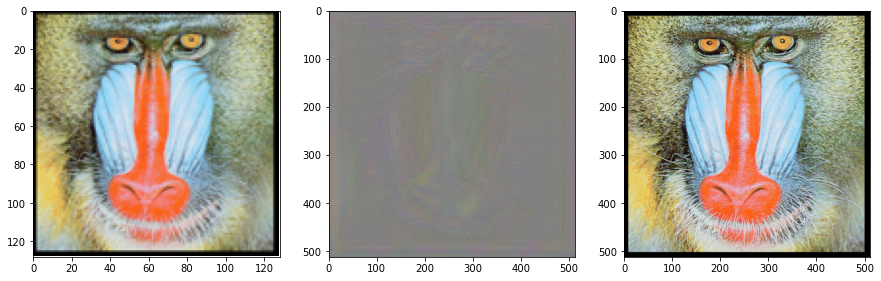

In [16]:
# placeholder code for displaying an image from generator
with torch.no_grad():
    img_lr = dataset.get_sample_by_name('baboon', 128)
    img_hr = dataset.get_sample_by_name('baboon', 512)
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    display_image(ax[0], img_lr)
    display_image(ax[1], generator.forward(torch.unsqueeze(img_lr.cuda().detach(), 0))[-1].cpu(), reverse_normalization=True)
    display_image(ax[2], img_hr)